In [1]:
import geopandas
import shapely
import numpy
import matplotlib.pyplot
import scipy.interpolate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import a single polyline and explore creating a spline through it

In [2]:
channel = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000\rec_main_channel.geojson")

In [3]:
resolution = 1

# Polyline sampling functions

In [4]:
def get_corner_points(channel) -> numpy.ndarray:
    x = []; y = []
    for line_string in channel.geometry:
        xy = line_string.xy
        x.extend(xy[0][::-1]); y.extend(xy[1][::-1])

    xy = numpy.array([x, y])
    xy_unique, indices = numpy.unique(xy, axis=1, return_index=True)
    indices.sort(); xy = xy[:, indices]
    return xy

In [5]:
def get_spaced_points_with_corners(channel, spacing) -> numpy.ndarray:
    xy_spaced = []
    for line_string in channel.geometry:
        
        xy_segment = line_string.xy
        x = xy_segment[0]; y = xy_segment[1]
        for i in numpy.arange(len(x) - 1, 0, -1):
            line_segment = shapely.geometry.LineString([[x[i], y[i]], [x[i - 1], y[i - 1]]])

            number_segment_samples = max(numpy.round(line_segment.length / spacing), 2)
            segment_resolution = line_segment.length / (number_segment_samples - 1)

            xy_spaced.extend([line_segment.interpolate(i * segment_resolution) for i in numpy.arange(0, number_segment_samples)])
        
    xy=numpy.array(shapely.geometry.LineString(xy_spaced).xy)
    xy_unique, indices = numpy.unique(xy, axis=1, return_index=True)
    indices.sort()
    xy = xy[:, indices]

    return xy

In [6]:
def get_spaced_points(channel, spacing) -> numpy.ndarray:

    xy_corner_points = get_corner_points(channel)
    xy_spaced = []
    line_string = shapely.geometry.LineString(xy_corner_points.T)

    number_segment_samples = max(numpy.round(line_string.length / spacing), 2)
    segment_resolution = line_string.length / (number_segment_samples - 1)

    xy_spaced.extend([line_string.interpolate(i * segment_resolution) for i in numpy.arange(number_segment_samples - 1, -1, -1)])
        
    xy=numpy.array(shapely.geometry.LineString(xy_spaced).xy)
    xy_unique, indices = numpy.unique(xy, axis=1, return_index=True)
    indices.sort()
    xy = xy[:, indices]

    return xy

# Parametric spline fit - interpolation
Note _smoothing_multipiler_ allows for some smoothing!

In [7]:
def fit_spline_to_points(xy, res, smoothing_multiplier) -> numpy.ndarray:
    
    smoothing_factor = smoothing_multiplier * len(xy[0])
    
    tck_tuple, u_input = scipy.interpolate.splprep(xy, s=smoothing_factor)

    # Sample every roughly res along the spine
    line_length = shapely.geometry.LineString(xy.T).length
    sample_step_u = 1 / round(line_length / res)
    u_sampled = numpy.arange(0, 1 + sample_step_u, sample_step_u)
    xy_sampled = scipy.interpolate.splev(u_sampled, tck_tuple)
    xy_sampled = numpy.array(xy_sampled)
    
    return xy_sampled

## Spline fit from corner points only
Does not follow line very well in between

[Text(0.5, 1.0, 'Centreline from corner points')]

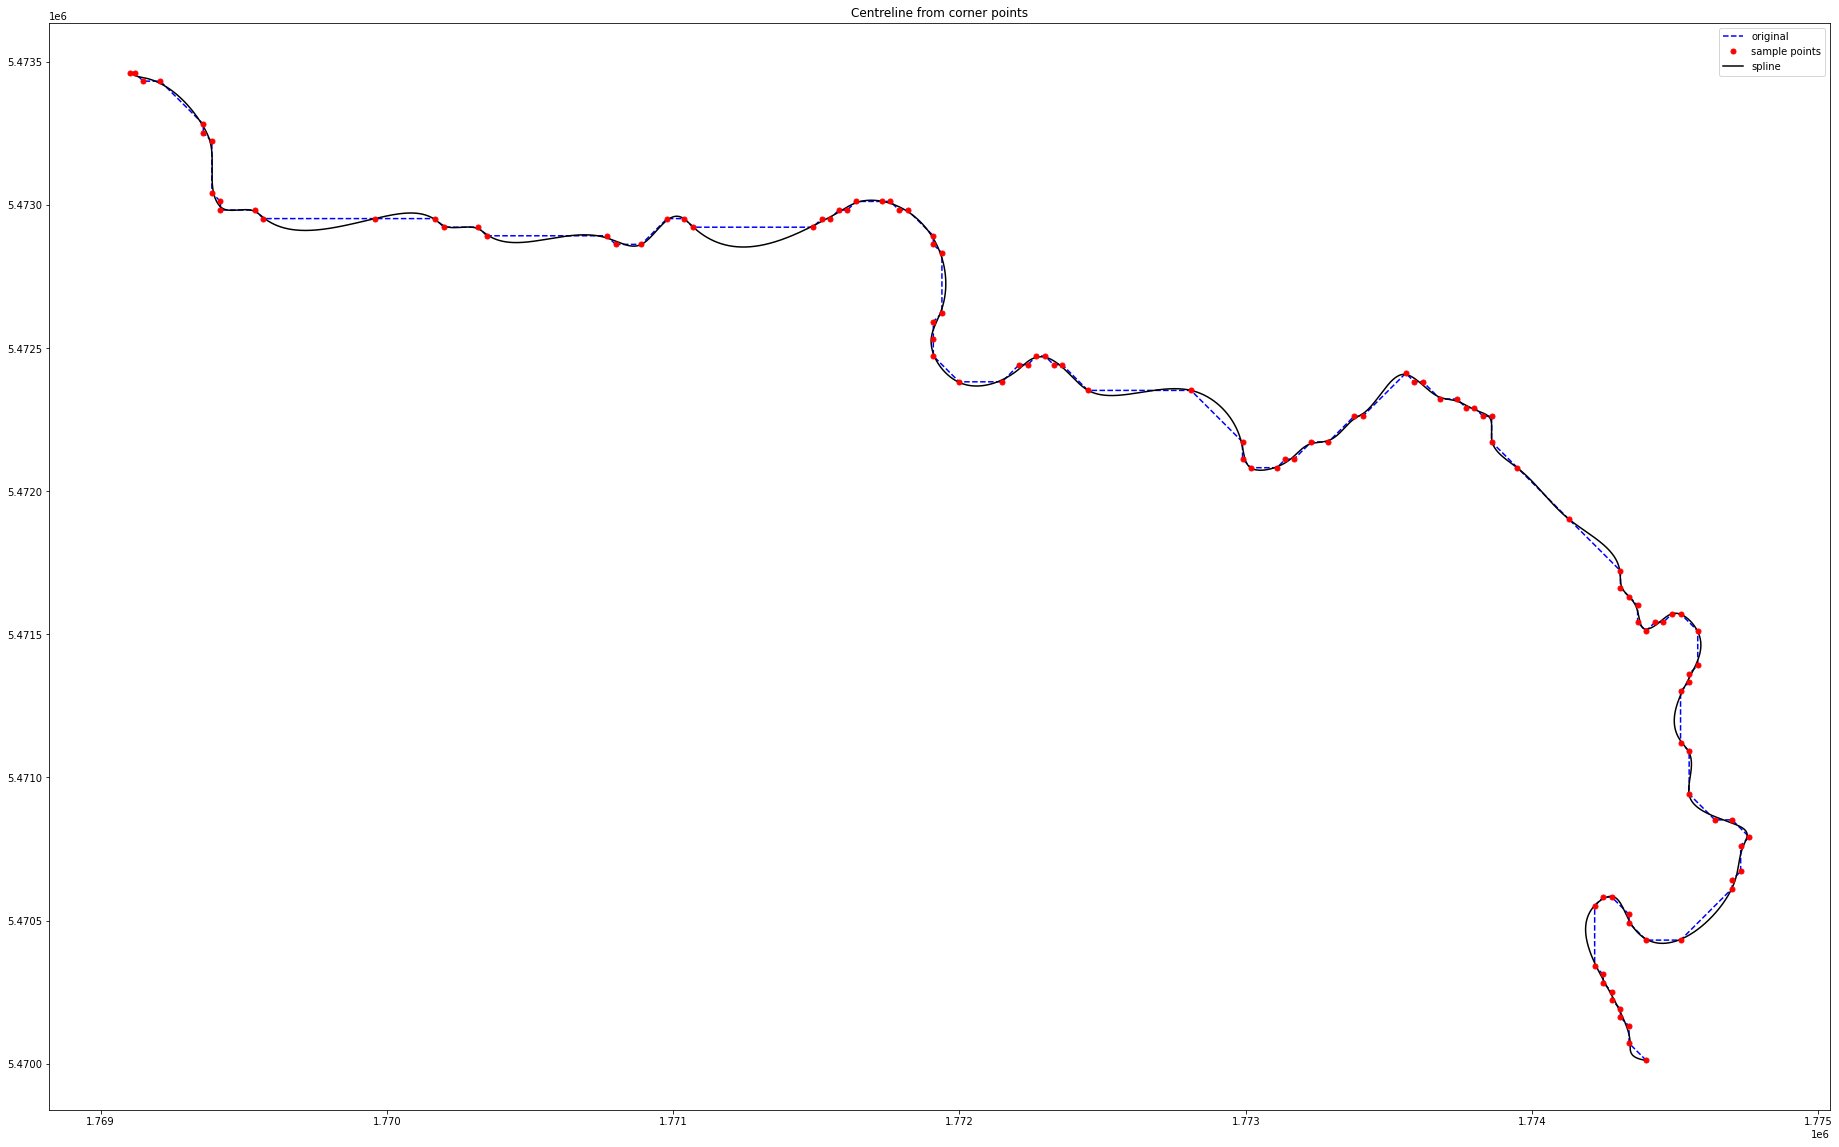

In [9]:
smoothing_multiplier = 50
xy_c1 = get_corner_points(channel)
xy_s1 = fit_spline_to_points(xy_c1, resolution, smoothing_multiplier)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c1[0], xy_c1[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s1[0], xy_s1[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from corner points")

In [10]:
xy_c1

array([[1769103.6309, 1769118.6313, 1769148.6313, 1769208.633 ,
        1769358.6331, 1769358.6322, 1769388.6322, 1769388.6269,
        1769418.6269, 1769418.626 , 1769538.6294, 1769568.6294,
        1769958.6409, 1770168.6473, 1770198.6473, 1770318.651 ,
        1770348.651 , 1770768.6644, 1770798.6644, 1770888.6674,
        1770978.6732, 1771038.6752, 1771068.6752, 1771488.6895,
        1771518.6916, 1771548.6926, 1771578.6946, 1771608.6957,
        1771638.6977, 1771728.7009, 1771758.702 , 1771788.7021,
        1771818.7031, 1771908.7034, 1771908.7024, 1771938.7025,
        1771938.6954, 1771908.6933, 1771908.6912, 1771908.6891,
        1771998.6892, 1772148.6946, 1772208.6988, 1772238.6999,
        1772268.7021, 1772298.7032, 1772328.7032, 1772358.7043,
        1772448.7044, 1772808.7179, 1772988.7182, 1772988.7159,
        1773018.716 , 1773108.7194, 1773138.7217, 1773168.7229,
        1773228.7274, 1773288.7298, 1773378.7367, 1773408.7378,
        1773558.7494, 1773588.7495, 1773

In [11]:
xy_s1

array([[1769104.51389038, 1769105.18548382, 1769105.86665011, ...,
        1774393.80570739, 1774395.94234614, 1774398.13737984],
       [5473464.06051265, 5473463.25480983, 5473462.47503847, ...,
        5470012.42613244, 5470012.07254235, 5470011.73177228]])

## Spline fit from space points
Space but loses corner points
Still interpolation - Goes through each point

[Text(0.5, 1.0, 'Centreline from points spaced by 50')]

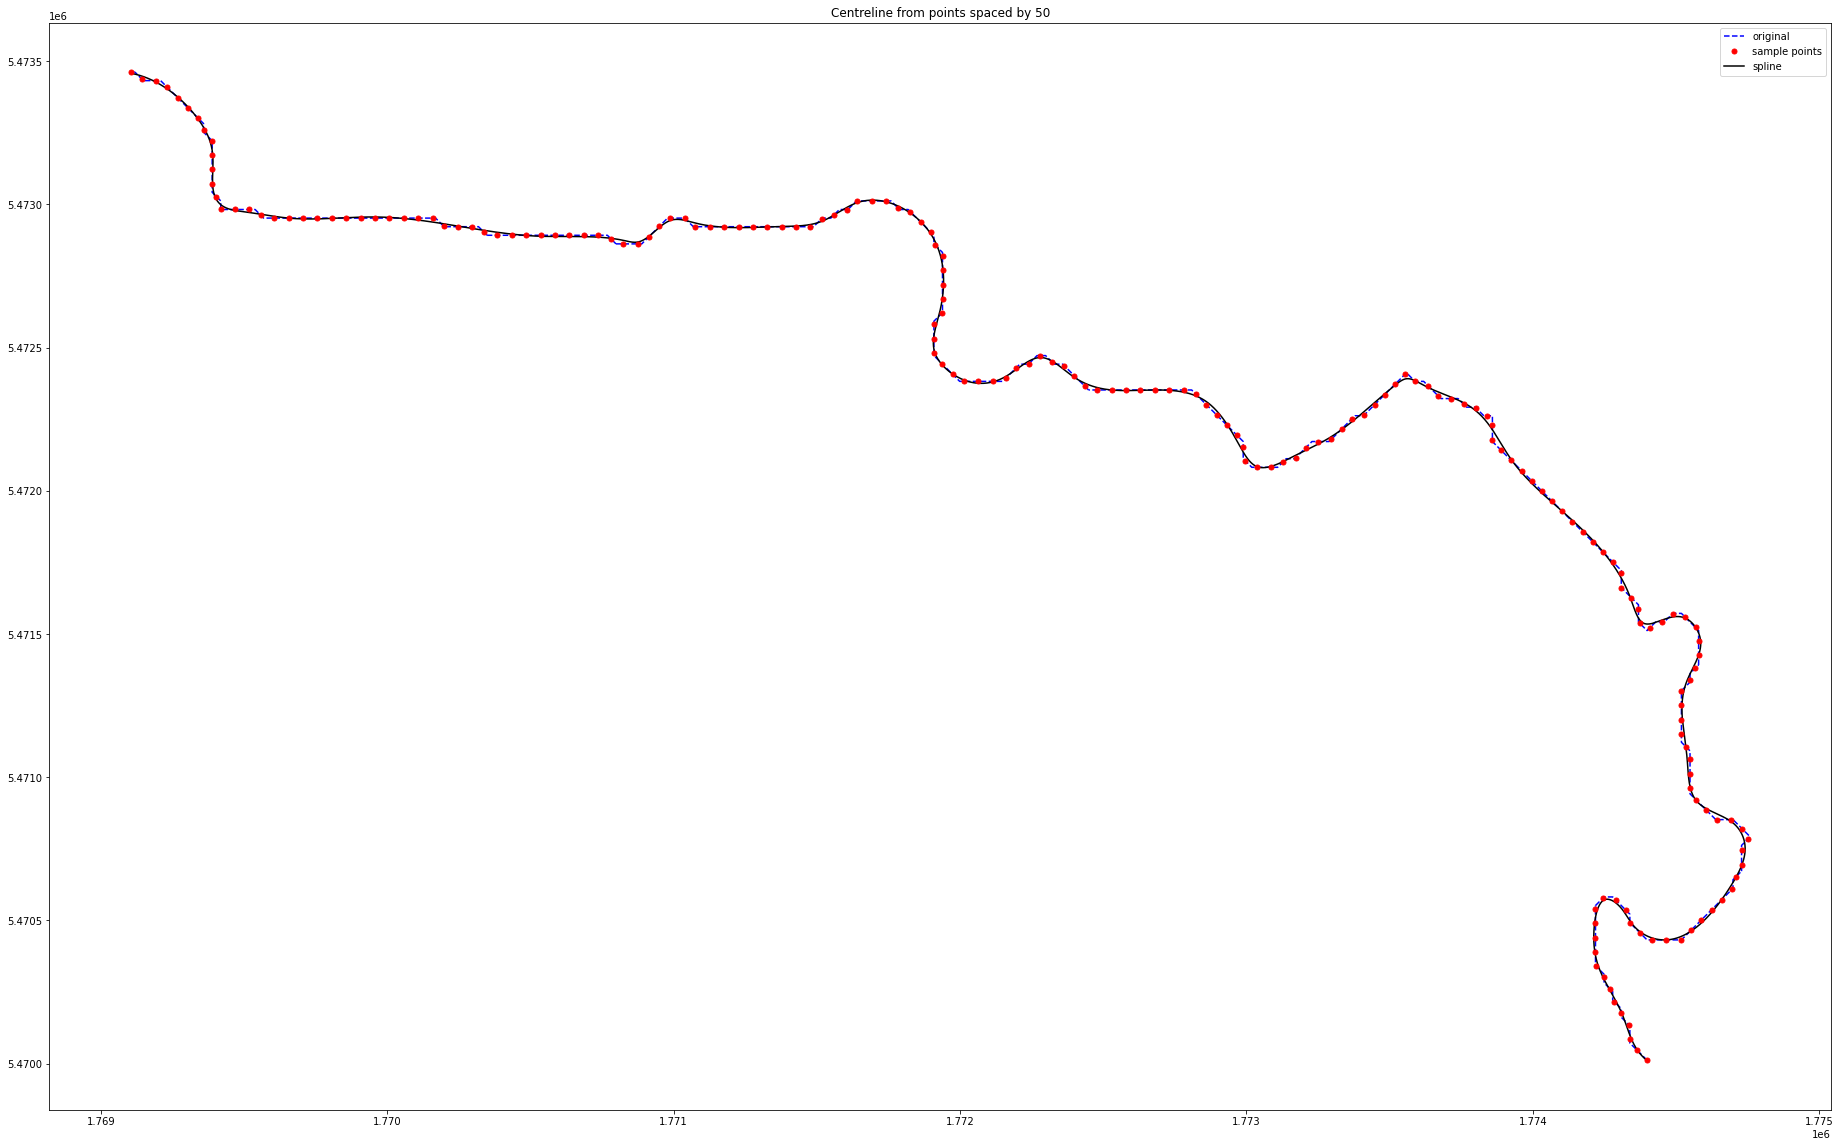

In [12]:
spacing = 50; smoothing_multiplier = 50
xy_c2 = get_spaced_points(channel, spacing)
xy_s2 = fit_spline_to_points(xy_c2, resolution, smoothing_multiplier)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c2[0], xy_c2[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s2[0], xy_s2[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from points spaced by {spacing}")

## Spline fit from space points
Spaced but keeps corner points

Number of points to fit: 172


[Text(0.5, 1.0, 'Centreline from points spaced by 50 with corner points and a smoothing multiplier of 50')]

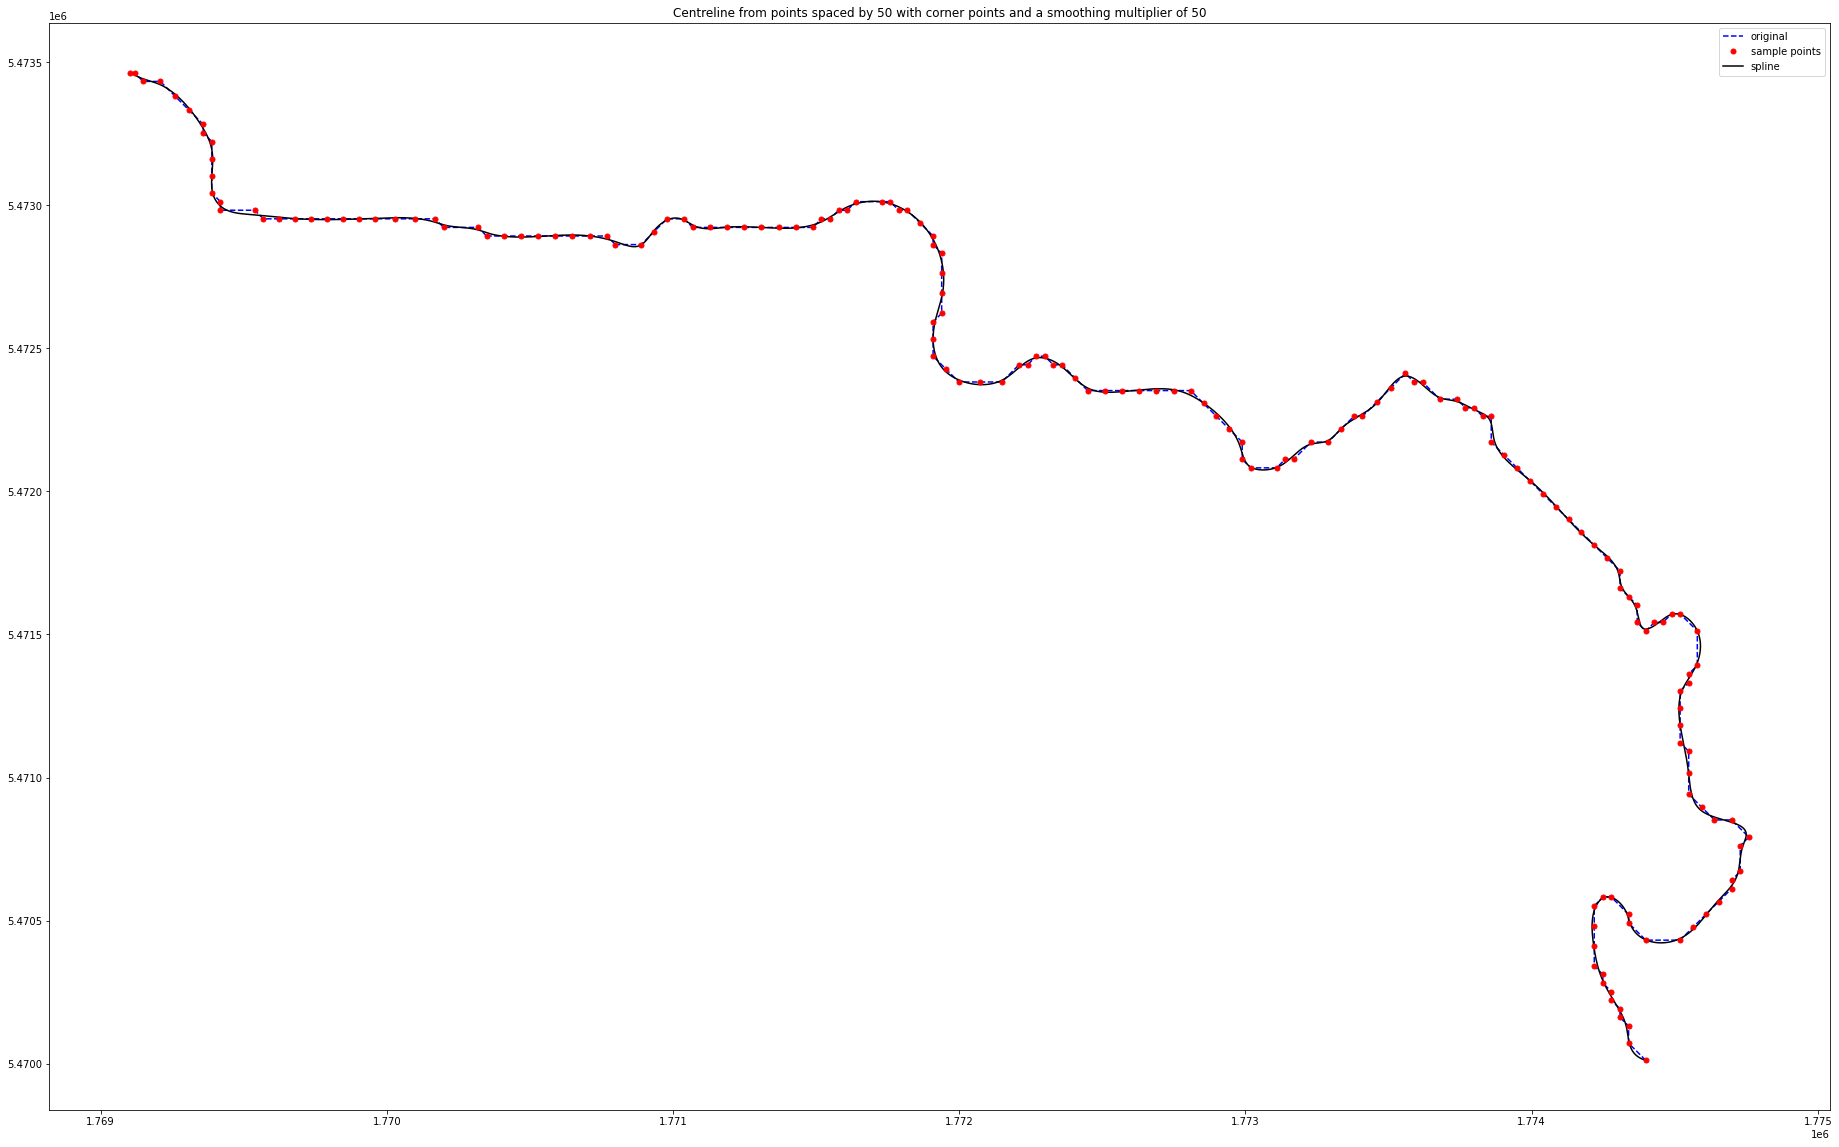

In [13]:
spacing = 50; smoothing_multiplier = 50
xy_c3 = get_spaced_points_with_corners(channel, spacing)
print(f"Number of points to fit: {len(xy_c3[0])}")
xy_s3 = fit_spline_to_points(xy_c3, resolution, smoothing_multiplier)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c3[0], xy_c3[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s3[0], xy_s3[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from points spaced by {spacing} with corner points and a smoothing multiplier of {smoothing_multiplier}")

Number of points to fit: 172


[Text(0.5, 1.0, 'Centreline from points spaced by 50 with corner points and a smoothing multiplier of 500')]

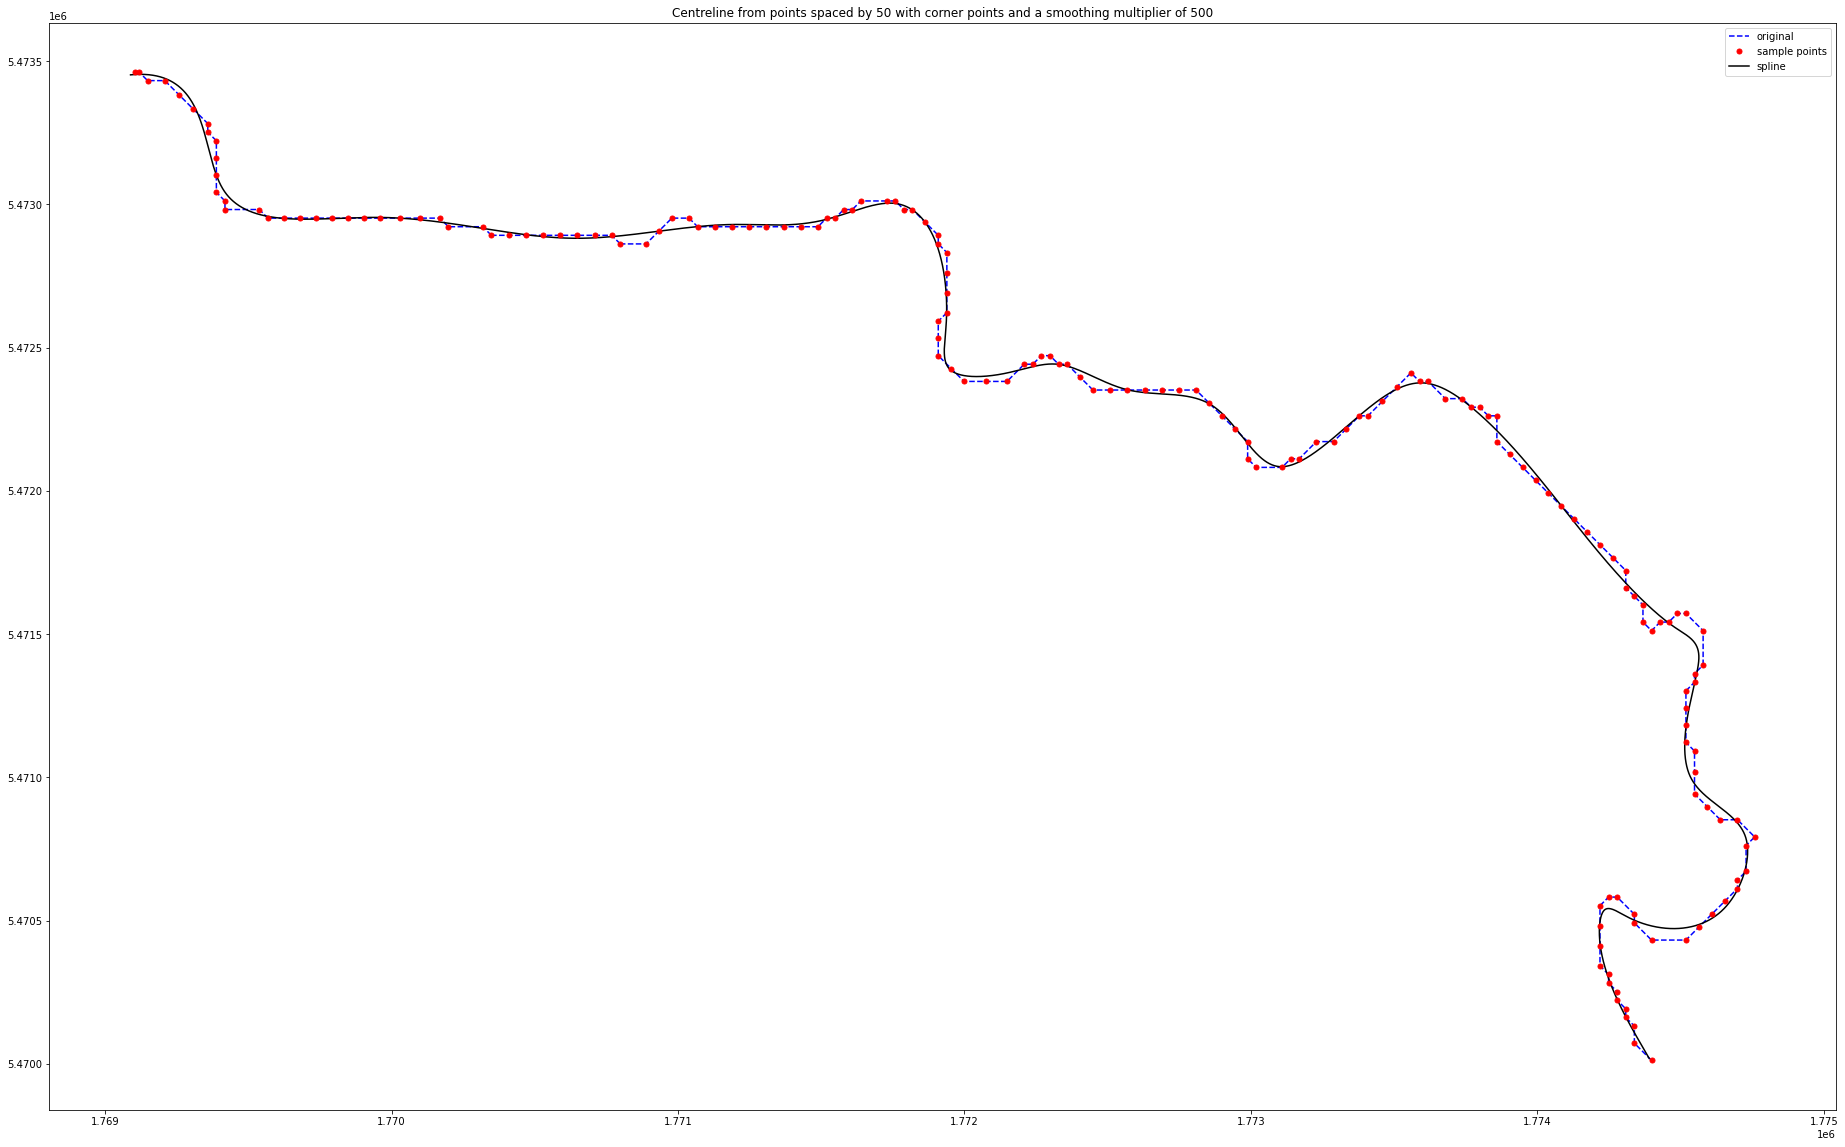

In [14]:
spacing = 50; smoothing_multiplier = 500
xy_c3 = get_spaced_points_with_corners(channel, spacing)
print(f"Number of points to fit: {len(xy_c3[0])}")
xy_s3 = fit_spline_to_points(xy_c3, resolution, smoothing_multiplier)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c3[0], xy_c3[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s3[0], xy_s3[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from points spaced by {spacing} with corner points and a smoothing multiplier of {smoothing_multiplier}")

# Parametric spline fit - control points
Based on: http://vadym-pasko.com/blog/2015/03/06/spline-approx-scipy.html

In [15]:
def fit_spline_to_points_from_knots(xy, res, k=3) -> numpy.ndarray:
    
    knotspace = range(len(xy[0]))
    knots = scipy.interpolate.InterpolatedUnivariateSpline(knotspace, knotspace, k=k).get_knots()
    knots_full = numpy.concatenate(([knots[0]] * k, knots, [knots[-1]] * k))
    
    tckX = knots_full, xy[0], k
    tckY = knots_full, xy[1], k

    splineX = scipy.interpolate.UnivariateSpline._from_tck(tckX)
    splineY = scipy.interpolate.UnivariateSpline._from_tck(tckY)

    # get number of points to sample spline at
    line_length = shapely.geometry.LineString(xy.T).length
    number_of_samples = round(line_length / res)

    u_sampled = numpy.linspace(0, len(xy[0]) - 1, number_of_samples)
    x_sampled = splineX(u_sampled)
    y_sampled = splineY(u_sampled)
    
    
    
    return numpy.array([x_sampled, y_sampled])

## Spline fit from  corner points only

[Text(0.5, 1.0, 'Centreline from corner points')]

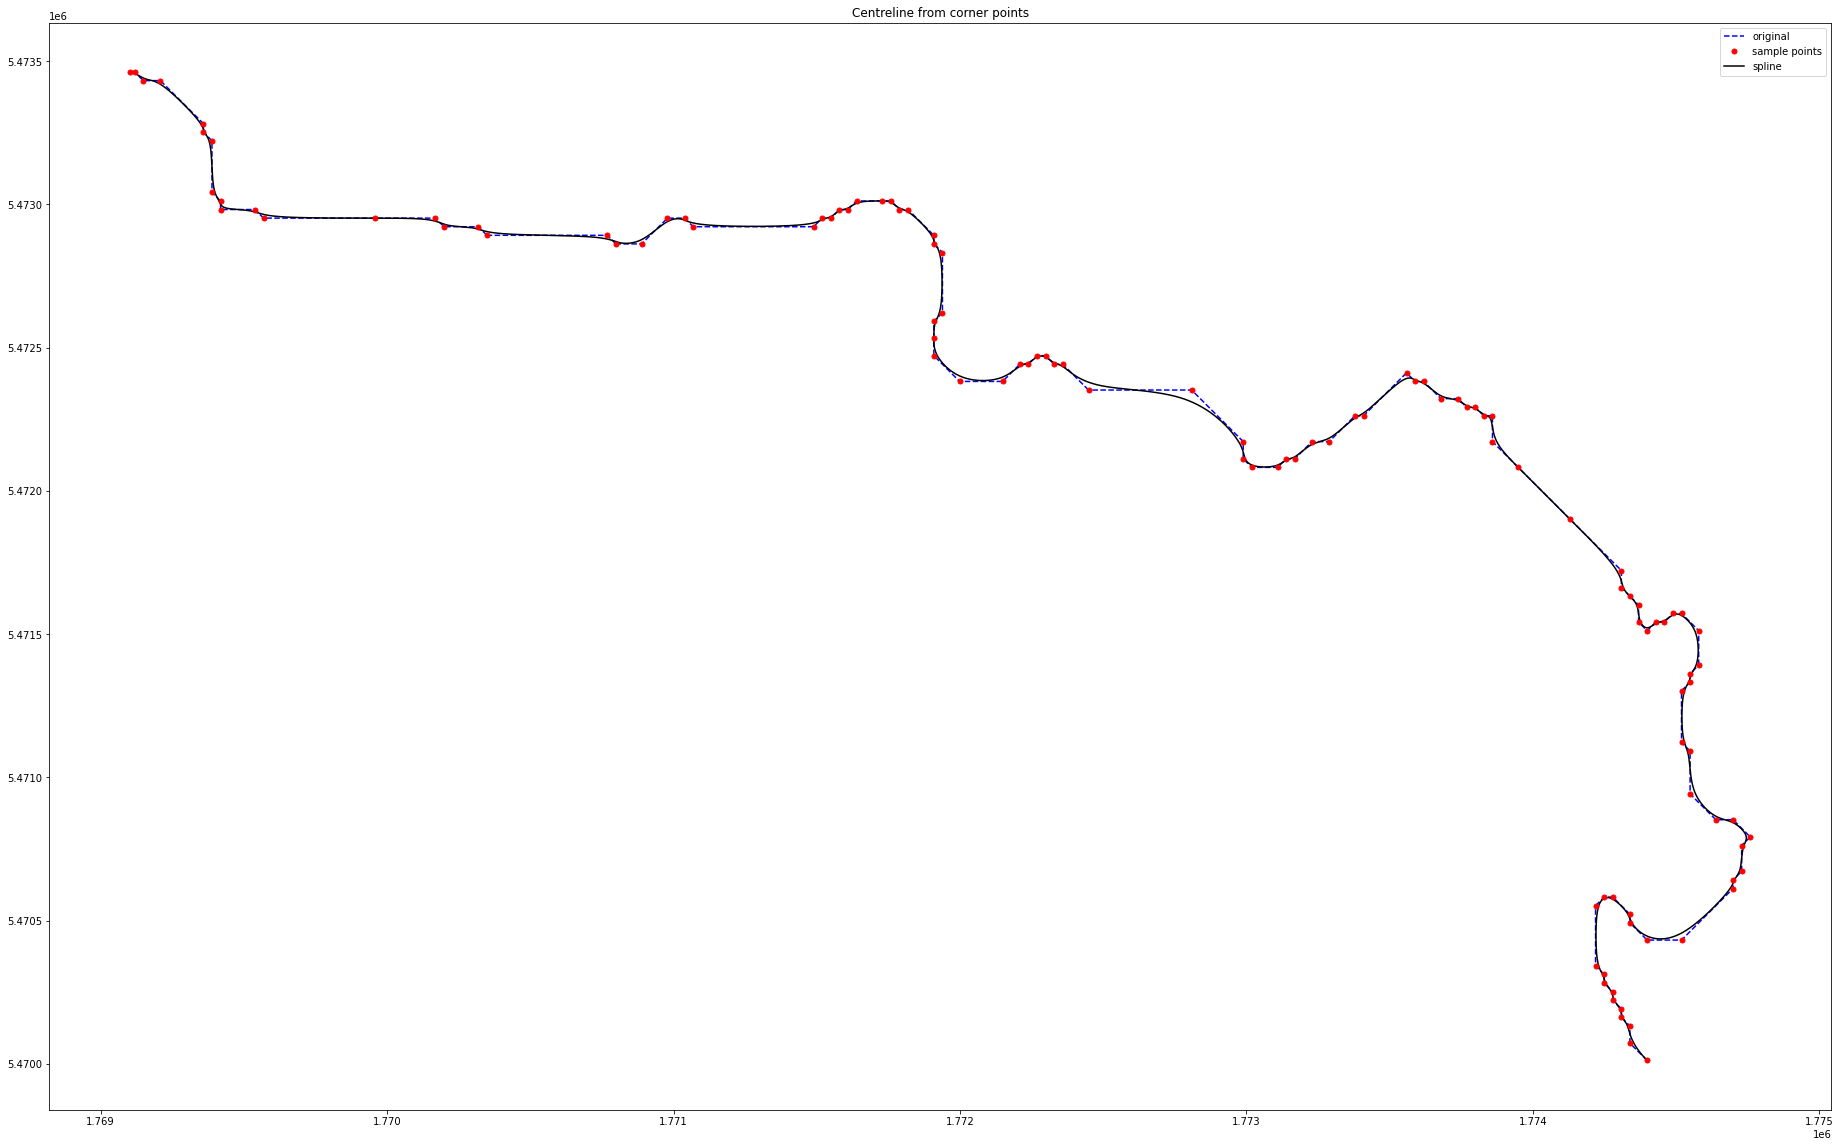

In [16]:
xy_c4 = get_corner_points(channel)
xy_s4 = fit_spline_to_points_from_knots(xy_c4, resolution)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c4[0], xy_c4[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s4[0], xy_s4[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from corner points")

## Spline fit from spaced points

[Text(0.5, 1.0, 'Centreline from corner points')]

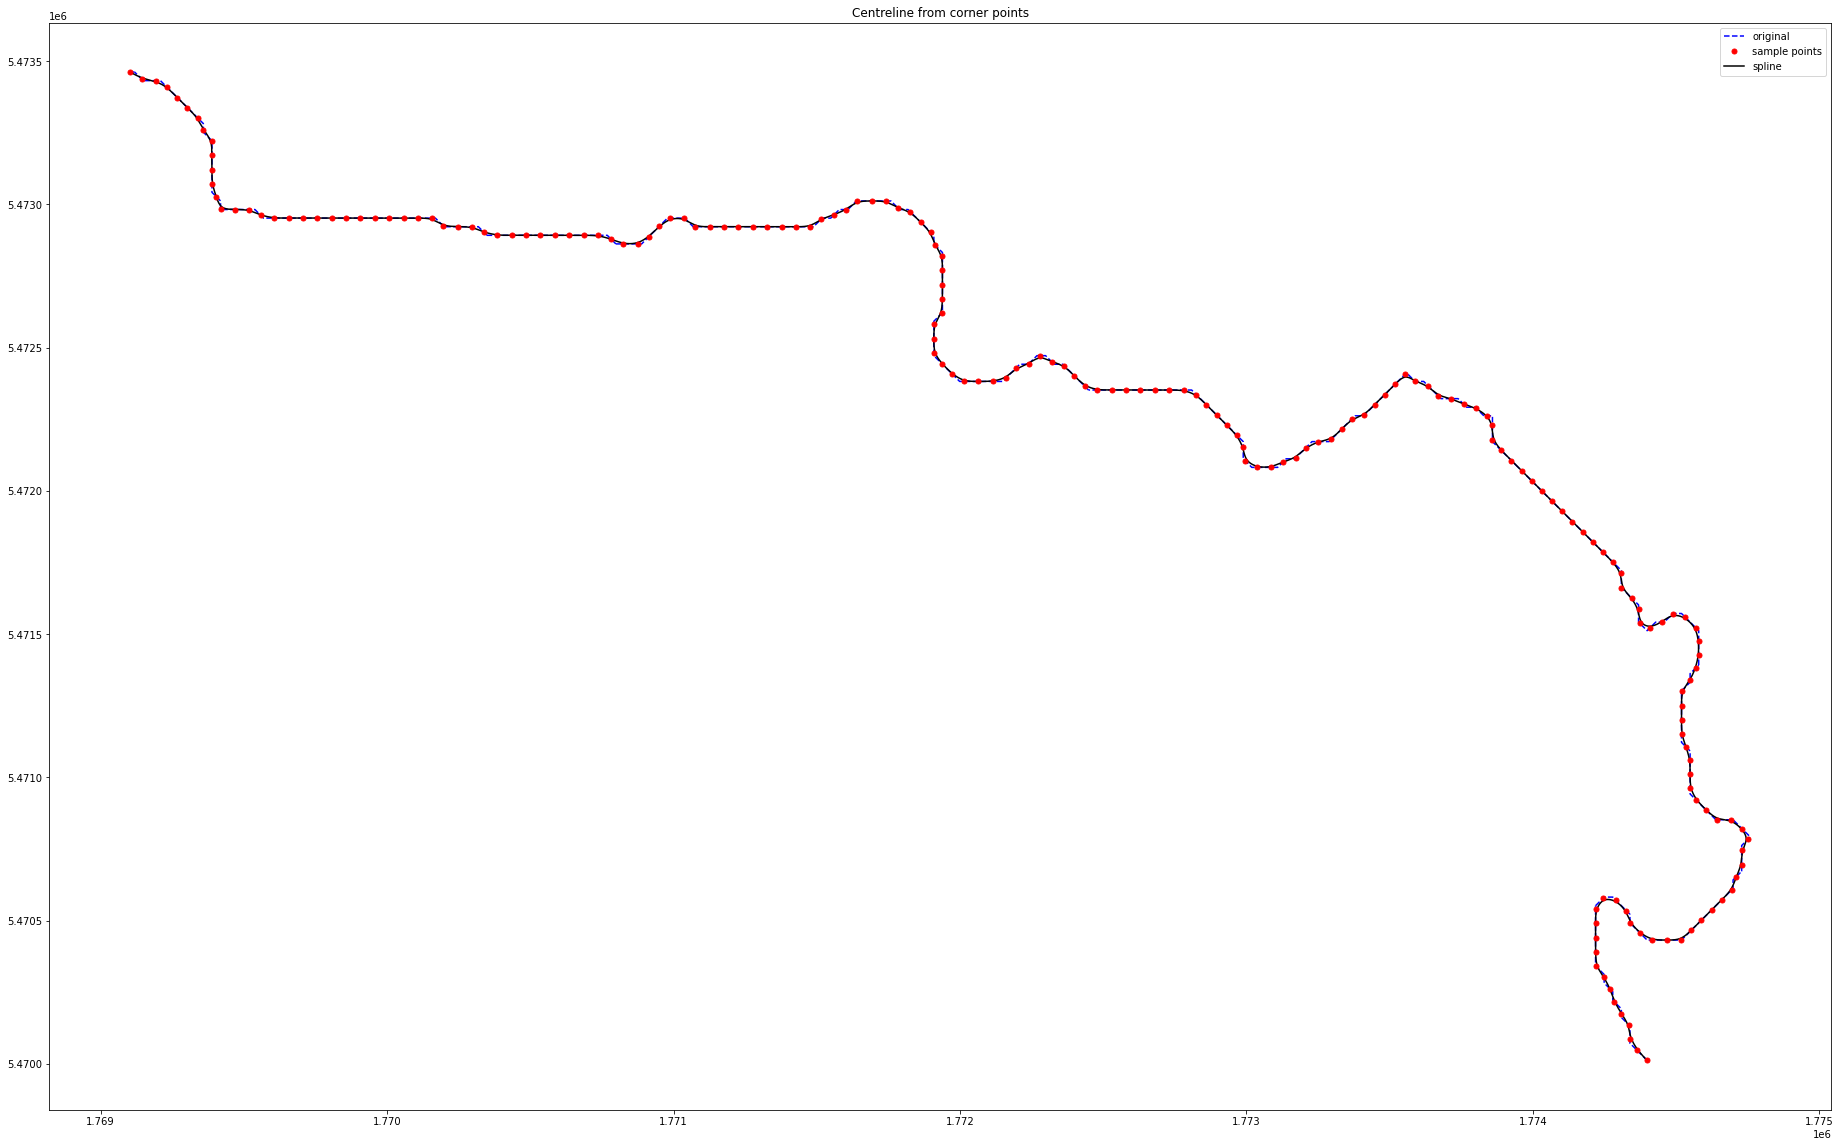

In [17]:
spacing = 50
xy_c5 = get_spaced_points(channel, spacing)
xy_s5 = fit_spline_to_points_from_knots(xy_c5, resolution)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c5[0], xy_c5[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s5[0], xy_s5[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from corner points")

## Spline fit from spaced points with corners

[Text(0.5, 1.0, 'Centreline from corner points')]

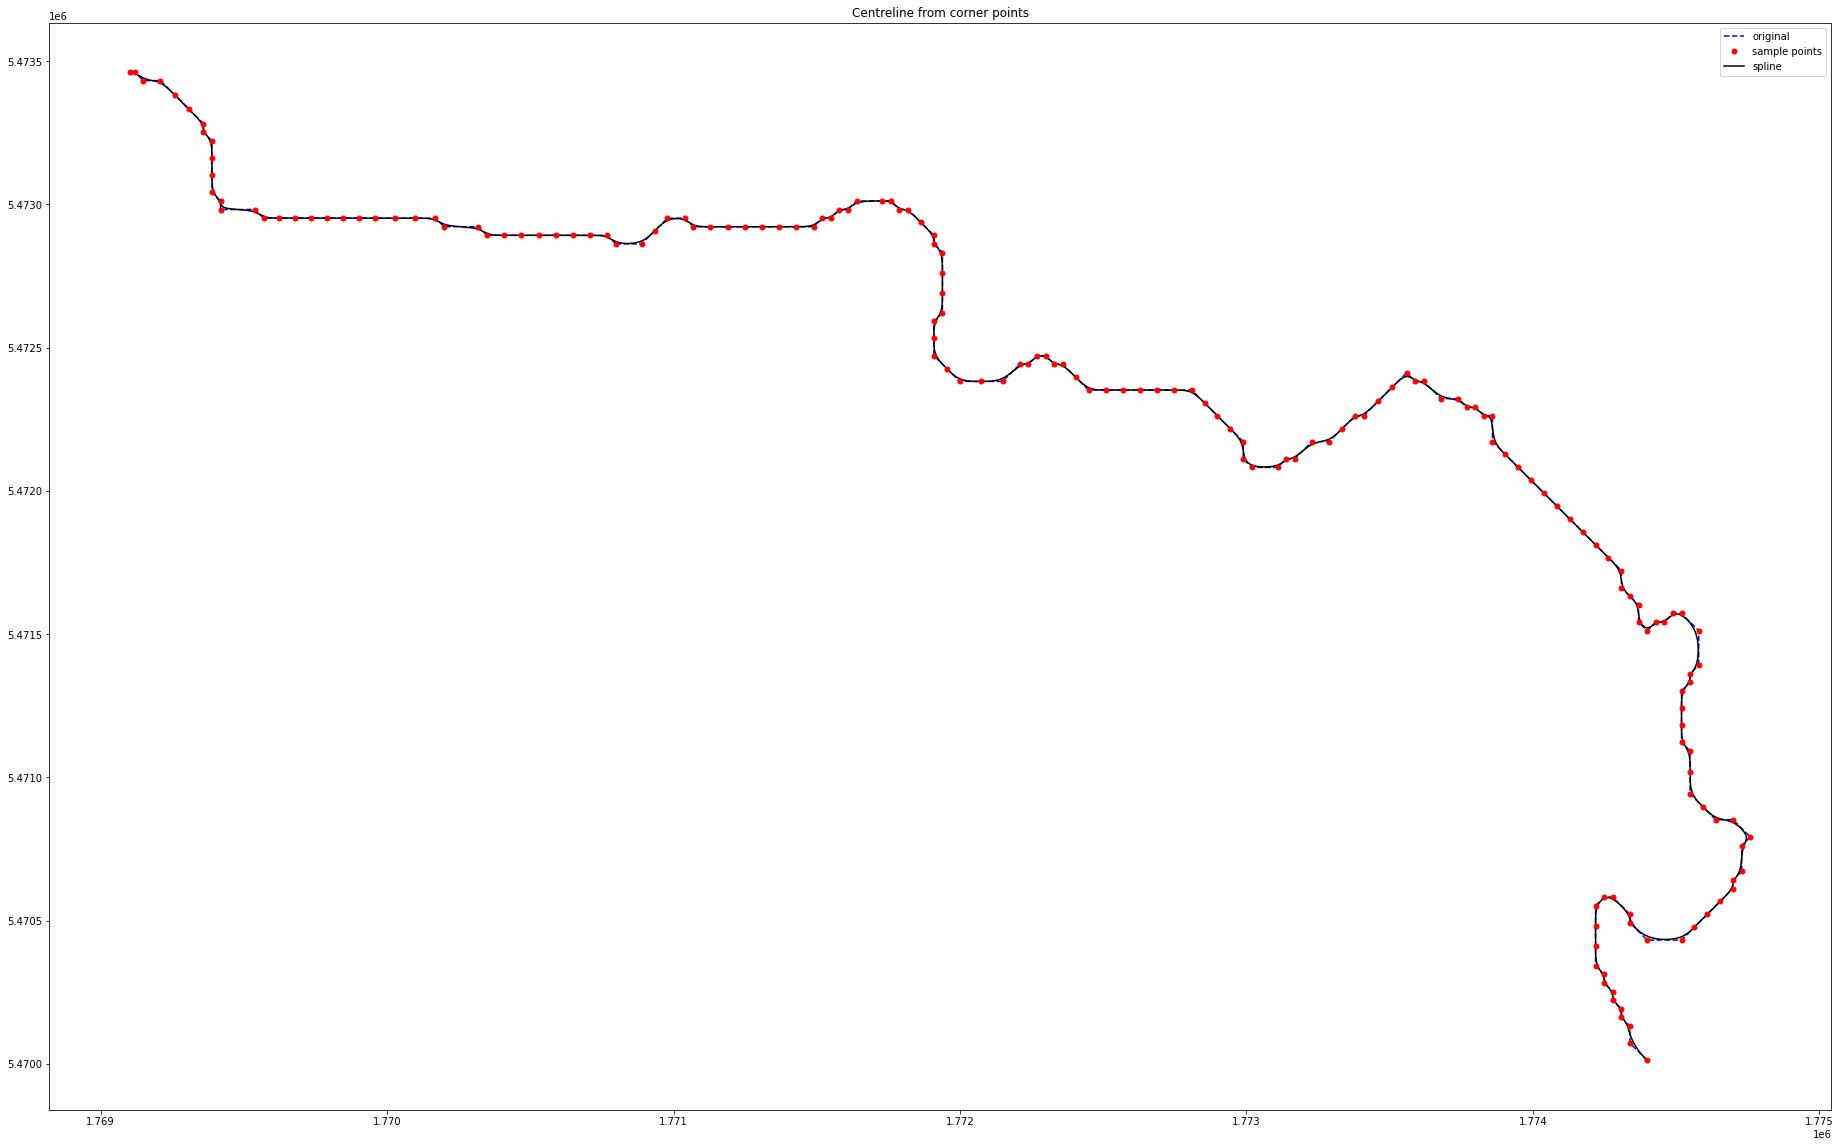

In [18]:
spacing = 50
xy_c6 = get_spaced_points_with_corners(channel, spacing)
xy_s6 = fit_spline_to_points_from_knots(xy_c6, resolution)

f, ax = matplotlib.pyplot.subplots(figsize=(40,20));
channel.plot(ax=ax, linestyle='--', markersize=1, label='original', color='b', zorder=0); 
matplotlib.pyplot.plot(xy_c6[0], xy_c6[1], 'ro', markersize=5, label='sample points', zorder=2);
matplotlib.pyplot.plot(xy_s6[0], xy_s6[1], 'k-', markersize=1, label='spline', zorder=1);
matplotlib.pyplot.legend(); ax.set(title=f"Centreline from corner points")